# MBA em Ciência de Dados - TCC
# Predição da Radiação Solar para Produção de Hidrogênio Verde: Análise comparativa de métodos de Aprendizado de Máquina

## Resultados - Visualização
**Material Produzido por:** Mateus Vasconcelos Albuquerque

**Cemeai - ICMC/USP São Carlos**


---------------------------------------------------------------------------------------------------------





In [1]:
from google.colab import drive
import os

# Monta o Google Drive
drive.mount('/content/drive')

# Define o caminho da pasta 'Projetos'
projetos_path = '/content/drive/My Drive/MBA/TCC/Projeto'

# Define o diretório de trabalho para a pasta 'Projetos'
if os.path.exists(projetos_path):
    os.chdir(projetos_path)
    print(f"Diretório alterado para: {projetos_path}")
else:
    print(f"A pasta 'Projetos' não foi encontrada em: {projetos_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Diretório alterado para: /content/drive/My Drive/MBA/TCC/Projeto


In [2]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model

In [3]:
# 📌 1. CARREGAR MODELOS DO REPOSITÓRIO output_forecast/
models = {
    "SVR": joblib.load("output_forecast/svr_random_search_model.joblib"),
    "RandomForest": joblib.load("output_forecast/random_forest_random_search_model.joblib"),
    "XGBoost": joblib.load("output_forecast/xgb_random_search_model.joblib"),
    "LSTM": load_model("output_forecast/lstm_random_search.keras")
}

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator SVR from version 1.5.1 when using version 1.3.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.6.0 when using version 1.3.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.6.0 when using version 1.3.1. This might lead to breaking code 

In [4]:
# 📌 2. SALVAR HIPERPARÂMETROS EM UM DICIONÁRIO
hyperparameters = {}
for model_name, model in models.items():
    if model_name == "RandomForest":
        best_params = {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 100}
        hyperparameters[model_name] = best_params
    elif model_name == "XGBoost":
        best_params = {'subsample': 0.9, 'reg_lambda': 0.1, 'reg_alpha': 0, 'n_estimators': 100, 'min_child_weight': 7, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.7}
        hyperparameters[model_name] = best_params
    elif hasattr(model, 'get_params'):
        hyperparameters[model_name] = model.get_params()
    elif model_name == 'LSTM':
        # Definindo os hiperparâmetros manualmente para o LSTM
        best_params = {
            'neurons': 32,
            'learning_rate': 0.001,
            'layers': 2,
            'dropout': 0.2,
            'epochs': 50,
            'batch_size': 32
        }
        hyperparameters[model_name] = best_params
    else:
        hyperparameters[model_name] = "Hiperparâmetros não disponíveis"

# Exibindo os hiperparâmetros
for model_name, params in hyperparameters.items():
    print(f"Hiperparâmetros do {model_name}: {params}")


Hiperparâmetros do SVR: {'C': 10, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.001, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Hiperparâmetros do RandomForest: {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 100}
Hiperparâmetros do XGBoost: {'subsample': 0.9, 'reg_lambda': 0.1, 'reg_alpha': 0, 'n_estimators': 100, 'min_child_weight': 7, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.7}
Hiperparâmetros do LSTM: {'neurons': 32, 'learning_rate': 0.001, 'layers': 2, 'dropout': 0.2, 'epochs': 50, 'batch_size': 32}


In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

In [6]:
# 📌 3. FUNÇÃO PARA CRIAR O MODELO LSTM
def lstm_model(X_train, neurons=50, layers=1, dropout=0.2, learning_rate=0.001):
    model = Sequential()
    for i in range(layers):
        return_sequences = i < layers - 1  # Retorna sequências até a penúltima camada
        # Definindo o input_shape somente na primeira camada
        if i == 0:
            model.add(LSTM(neurons, return_sequences=return_sequences, input_shape=(X_train.shape[1], X_train.shape[2])))
        else:
            model.add(LSTM(neurons, return_sequences=return_sequences))
        model.add(Dropout(dropout))
    model.add(Dense(1))  # Camada de saída
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
    return model

In [7]:
# 📌 4. CARREGAR DADOS TREINAMENTO & TESTE ORIGINAIS
X_tr_top = pd.read_csv("output_forecast/X_tr_top.csv", index_col=0)
X_ts_top = pd.read_csv("output_forecast/X_ts_top.csv", index_col=0)
Y_tr_scaled = pd.read_csv("output_forecast/Y_tr_scaled.csv", index_col=0).values.ravel()
Y_ts_scaled = pd.read_csv("output_forecast/Y_ts_scaled.csv", index_col=0).values.ravel()

scaler_X = joblib.load("output_forecast/scaler.joblib")
scaler_Y = joblib.load("output_forecast/scaler_y.joblib")

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.3.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [8]:
# show all columns
pd.set_option('display.max_columns', None)

In [9]:
# 📌 5. CARREGAR DADOS ORIGINAIS PARA O LSTM
X_train_lstm = np.load("output_forecast/X_train_lstm.npy")
X_test_lstm = np.load("output_forecast/X_test_lstm.npy")
y_train_lstm = np.load("output_forecast/y_train_lstm.npy")
y_test_lstm = np.load("output_forecast/y_test_lstm.npy")

scaler_X_lstm = joblib.load("output_forecast/scaler_X_lstm.joblib")
scaler_Y_lstm = joblib.load("output_forecast/scaler_y_lstm.joblib")

In [10]:
# Convertendo o índice para datetime, se necessário
X_tr_top.index = pd.to_datetime(X_tr_top.index)
X_ts_top.index = pd.to_datetime(X_ts_top.index)

# Baixar dados de Jaguaribe

In [11]:
import pandas as pd
from pandas.plotting import lag_plot
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import yaml
import os

In [12]:
# Leitura do arquivo de configuração

# folder para carregar os config files
CONFIG_PATH = "config/"

# Função para carregar os dados
def load_config(config_name):
    with open(os.path.join(CONFIG_PATH, config_name)) as file:
        config = yaml.safe_load(file)

    return config

In [13]:
config = load_config("data_preprocessing_config_jaguaribe.yaml")

# mostrar todas as colunas
pd.set_option("display.max_columns", None)

In [14]:
# Leitura dos dados a partir do CSV
codigo_wmo = config["input_data_parameters"]["codigo_wmo"]
estacao = config["input_data_parameters"]["estacao"]

input_dir = config["output_directory_preprocessing"]

filepath = f"{input_dir}/preprocessed_data_{codigo_wmo}_{estacao}.csv"

data = pd.read_csv(
    filepath,
    index_col=0,
)

# # remove last 5 columns
# data = data.iloc[:, :-5]

In [15]:
def time_delay_embedding(series: pd.Series, n_lags: int, horizon: int):
    """
    Time delay embedding
    Time series for supervised learning

    :param series: time series as pd.Series
    :param n_lags: number of past values to used as explanatory variables
    :param horizon: how many values to forecast

    :return: pd.DataFrame with reconstructed time series
    """
    assert isinstance(series, pd.Series)

    if series.name is None:
        name = 'Series'
    else:
        name = series.name

    n_lags_iter = list(range(n_lags, -horizon, -1))

    X = [series.shift(i) for i in n_lags_iter]
    X = pd.concat(X, axis=1).dropna()
    X.columns = [f'{name}(t-{j - 1})'
                 if j > 0 else f'{name}(t+{np.abs(j) + 1})'
                 for j in n_lags_iter]

    return X

In [16]:
# create data set with lagged features using time delay embedding
radiation_ds = []
for col in data.iloc[:, :-5]:
    col_df = time_delay_embedding(data[col], n_lags=25, horizon=1)
    radiation_ds.append(col_df)

# concatenating with last 5 columns of data
radiation_ds.append(data.iloc[:, -5:])

# concatenating all variables
radiation_df = pd.concat(radiation_ds, axis=1).dropna()

# remove columns ano, semana e dia_ano
radiation_df = radiation_df.drop(columns=["year", "semana", "dia_ano"])

In [17]:
# One-hot encoding para as variáveis categóricas
radiation_df = pd.get_dummies(radiation_df, columns=["mes", "hora"])

# Remover as colunas originais
# radiation_df = radiation_df.drop(columns=["hora", "mes"])

radiation_df.head()

,precipitacao_total_horario(t-24),precipitacao_total_horario(t-23),precipitacao_total_horario(t-22),precipitacao_total_horario(t-21),precipitacao_total_horario(t-20),precipitacao_total_horario(t-19),precipitacao_total_horario(t-18),precipitacao_total_horario(t-17),precipitacao_total_horario(t-16),precipitacao_total_horario(t-15),precipitacao_total_horario(t-14),precipitacao_total_horario(t-13),precipitacao_total_horario(t-12),precipitacao_total_horario(t-11),precipitacao_total_horario(t-10),precipitacao_total_horario(t-9),precipitacao_total_horario(t-8),precipitacao_total_horario(t-7),precipitacao_total_horario(t-6),precipitacao_total_horario(t-5),precipitacao_total_horario(t-4),precipitacao_total_horario(t-3),precipitacao_total_horario(t-2),precipitacao_total_horario(t-1),precipitacao_total_horario(t-0),precipitacao_total_horario(t+1),pressao_atmosferica_nivel_estacao_horaria(t-24),pressao_atmosferica_nivel_estacao_horaria(t-23),pressao_atmosferica_nivel_estacao_horaria(t-22),pressao_atmosferica_nivel_estacao_horaria(t-21),pressao_atmosferica_nivel_estacao_horaria(t-20),pressao_atmosferica_nivel_estacao_horaria(t-19),pressao_atmosferica_nivel_estacao_horaria(t-18),pressao_atmosferica_nivel_estacao_horaria(t-17),pressao_atmosferica_nivel_estacao_horaria(t-16),pressao_atmosferica_nivel_estacao_horaria(t-15),pressao_atmosferica_nivel_estacao_horaria(t-14),pressao_atmosferica_nivel_estacao_horaria(t-13),pressao_atmosferica_nivel_estacao_horaria(t-12),pressao_atmosferica_nivel_estacao_horaria(t-11),pressao_atmosferica_nivel_estacao_horaria(t-10),pressao_atmosferica_nivel_estacao_horaria(t-9),pressao_atmosferica_nivel_estacao_horaria(t-8),pressao_atmosferica_nivel_estacao_horaria(t-7),pressao_atmosferica_nivel_estacao_horaria(t-6),pressao_atmosferica_nivel_estacao_horaria(t-5),pressao_atmosferica_nivel_estacao_horaria(t-4),pressao_atmosferica_nivel_estacao_horaria(t-3),pressao_atmosferica_nivel_estacao_horaria(t-2),pressao_atmosferica_nivel_estacao_horaria(t-1),pressao_atmosferica_nivel_estacao_horaria(t-0),pressao_atmosferica_nivel_estacao_horaria(t+1),temperatura_ar_bulbo_seco_horaria(t-24),temperatura_ar_bulbo_seco_horaria(t-23),temperatura_ar_bulbo_seco_horaria(t-22),temperatura_ar_bulbo_seco_horaria(t-21),temperatura_ar_bulbo_seco_horaria(t-20),temperatura_ar_bulbo_seco_horaria(t-19),temperatura_ar_bulbo_seco_horaria(t-18),temperatura_ar_bulbo_seco_horaria(t-17),temperatura_ar_bulbo_seco_horaria(t-16),temperatura_ar_bulbo_seco_horaria(t-15),temperatura_ar_bulbo_seco_horaria(t-14),temperatura_ar_bulbo_seco_horaria(t-13),temperatura_ar_bulbo_seco_horaria(t-12),temperatura_ar_bulbo_seco_horaria(t-11),temperatura_ar_bulbo_seco_horaria(t-10),temperatura_ar_bulbo_seco_horaria(t-9),temperatura_ar_bulbo_seco_horaria(t-8),temperatura_ar_bulbo_seco_horaria(t-7),temperatura_ar_bulbo_seco_horaria(t-6),temperatura_ar_bulbo_seco_horaria(t-5),temperatura_ar_bulbo_seco_horaria(t-4),temperatura_ar_bulbo_seco_horaria(t-3),temperatura_ar_bulbo_seco_horaria(t-2),temperatura_ar_bulbo_seco_horaria(t-1),temperatura_ar_bulbo_seco_horaria(t-0),temperatura_ar_bulbo_seco_horaria(t+1),umidade_relativa_ar_horaria(t-24),umidade_relativa_ar_horaria(t-23),umidade_relativa_ar_horaria(t-22),umidade_relativa_ar_horaria(t-21),umidade_relativa_ar_horaria(t-20),umidade_relativa_ar_horaria(t-19),umidade_relativa_ar_horaria(t-18),umidade_relativa_ar_horaria(t-17),umidade_relativa_ar_horaria(t-16),umidade_relativa_ar_horaria(t-15),umidade_relativa_ar_horaria(t-14),umidade_relativa_ar_horaria(t-13),umidade_relativa_ar_horaria(t-12),umidade_relativa_ar_horaria(t-11),umidade_relativa_ar_horaria(t-10),umidade_relativa_ar_horaria(t-9),umidade_relativa_ar_horaria(t-8),umidade_relativa_ar_horaria(t-7),umidade_relativa_ar_horaria(t-6),umidade_relativa_ar_horaria(t-5),umidade_relativa_ar_horaria(t-4),umidade_relativa_ar_horaria(t-3),umidade_relativa_ar_horaria(t-2),umidade_relativa_ar_horaria(t-1),umidade_relativa_ar_horaria(t-0),umidade_relativa_ar_horaria(t+1),vento_direcao

In [18]:
# defining target (Y) and explanatory variables (X)
predictor_variables = radiation_df.columns.str.contains("\(t\-") | radiation_df.columns.str.contains(r"hora_") | radiation_df.columns.str.contains(r"mes_")
target_variables = radiation_df.columns.str.contains("radiacao_global\(t\+")

X = radiation_df.iloc[:, predictor_variables]
Y = radiation_df.iloc[:, target_variables]

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
from sklearn.ensemble import RandomForestRegressor

# train/test split
X_tr, X_ts, Y_tr, Y_ts = train_test_split(X, Y, test_size=0.3, shuffle=False)

In [20]:
from sklearn.preprocessing import MinMaxScaler

# Inicializar o Min-Max Scaler
scaler = MinMaxScaler()

# Ajustar o scaler nos dados de treino e transformar os dados de treino
X_tr_scaled = pd.DataFrame(scaler.fit_transform(X_tr), index=X_tr.index, columns=X_tr.columns)

# Transformar os dados de teste (usando o scaler ajustado nos dados de treino)
X_ts_scaled = pd.DataFrame(scaler.transform(X_ts), index=X_ts.index, columns=X_ts.columns)

In [21]:
# Ajustar o scaler nos dados de treino da variável alvo
scaler_y = MinMaxScaler()

# Escalar Y_tr e Y_ts
Y_tr_scaled = pd.DataFrame(scaler_y.fit_transform(Y_tr), index=Y_tr.index, columns=Y_tr.columns)
Y_ts_scaled = pd.DataFrame(scaler_y.transform(Y_ts), index=Y_ts.index, columns=Y_ts.columns)

In [22]:
# filtrar em X_tr_scaled e X_ts_scaled apenas as colunas contidas em X_tr_top
X_tr_top = X_tr_scaled.loc[:, X_tr_scaled.columns.isin(X_tr_top.columns)]
X_ts_top = X_ts_scaled.loc[:, X_ts_scaled.columns.isin(X_ts_top.columns)]

# Continuacão do processo padrão

In [23]:
# 📌 4. INSTANTIAR OS MODELOS COM OS MELHORES PARÂMETROS

# 1. SVR
svr_model = SVR(C=hyperparameters['SVR']['C'], epsilon=hyperparameters['SVR']['epsilon'], kernel=hyperparameters['SVR']['kernel'])

# 2. Random Forest
random_forest_best_parameters = hyperparameters['RandomForest']
print(random_forest_best_parameters)
# random_forest_model = RandomForestRegressor(**random_forest_best_parameters)
random_forest_model = RandomForestRegressor(
    n_estimators=hyperparameters['RandomForest']['n_estimators'],
    max_depth=hyperparameters['RandomForest']['max_depth'],
    max_features=hyperparameters['RandomForest']['max_features'],
    min_samples_split=hyperparameters['RandomForest']['min_samples_split'],
    min_samples_leaf=hyperparameters['RandomForest']['min_samples_leaf']
)

# 3. XGBoost
xgboost_model = xgb.XGBRegressor(learning_rate=hyperparameters['XGBoost']['learning_rate'],
                                 n_estimators=hyperparameters['XGBoost']['n_estimators'],
                                 max_depth=hyperparameters['XGBoost']['max_depth'],
                                 subsample=hyperparameters['XGBoost']['subsample'],
                                 colsample_bytree=hyperparameters['XGBoost']['colsample_bytree'],
                                 min_child_weight=hyperparameters['XGBoost']['min_child_weight'],
                                 reg_lambda=hyperparameters['XGBoost']['reg_lambda'],
                                 reg_alpha=hyperparameters['XGBoost']['reg_alpha'],
                                 gamma=hyperparameters['XGBoost']['gamma']
                                 )

# 4. LSTM

# Instanciando o modelo LSTM
lstm_model_instance = lstm_model(X_train_lstm, neurons=hyperparameters['LSTM']['neurons'],
                                 layers=hyperparameters['LSTM']['layers'], dropout=hyperparameters['LSTM']['dropout'],
                                 learning_rate=hyperparameters['LSTM']['learning_rate'])

# 📌 EXIBIR OS MODELOS INSTANCIADOS
print("Modelos instanciados:")
print(f"SVR: {svr_model}")
print(f"Random Forest: {random_forest_model}")
# Imprime os parâmetros configurados do modelo
print(f"Random Forest parâmetros: {random_forest_model.get_params()}")
print(f"XGBoost: {xgboost_model}")
print(f"LSTM: {lstm_model_instance.summary()}")

instance_models = {
    "SVR": svr_model,
    "RandomForest": random_forest_model,
    "XGBoost": xgboost_model
}

{'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 100}
Modelos instanciados:
SVR: SVR(C=10, epsilon=0.001)
Random Forest: RandomForestRegressor(max_depth=100, max_features='sqrt', n_estimators=1000)
Random Forest parâmetros: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 100, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1000, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
XGBoost: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 24, 32)              │           5,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,473 (52.63 KB)

 Trainable params: 13,473 (52.63 KB)

 Non-trainable params: 0 (0.00 B)

LSTM: None


In [24]:
# tscv = TimeSeriesSplit(n_splits=3)
# results = {name: {'mae': [], 'rmse': [], 'r2': []} for name in models.keys()}

# # Iterando pelos folds da validação cruzada
# for fold, (train_idx, test_idx) in enumerate(tscv.split(X_tr_top), 1):
#     print(f"Fold {fold}/{tscv.get_n_splits()}")

#     X_train, X_test = X_tr_top.iloc[train_idx], X_tr_top.iloc[test_idx]
#     y_train, y_test = Y_tr_scaled[train_idx], Y_tr_scaled[test_idx]

#     # Iterando pelos modelos
#     for name, model in models.items():
#         print(f" Treinando o modelo {name}...")

#         # if name == "LSTM":
#         #     X_train_lstm_cv, X_test_lstm_cv = X_train_lstm[train_idx], X_train_lstm[test_idx]
#         #     y_train_lstm_cv, y_test_lstm_cv = y_train_lstm[train_idx], y_train_lstm[test_idx]

#         #     model.fit(X_train_lstm_cv, y_train_lstm_cv, epochs=hyperparameters["LSTM"]["epochs"], batch_size=hyperparameters["LSTM"]["batch_size"], verbose=2)
#         #     y_pred = model.predict(X_test_lstm_cv)
#         #     y_pred = scaler_Y_lstm.inverse_transform(y_pred)
#         #     y_test = scaler_Y_lstm.inverse_transform(y_test_lstm_cv)
#         if name == "LSTM":
#             # Criando uma nova instância do modelo LSTM antes de cada fold
#             lstm_model_instance = lstm_model(
#                 X_train_lstm,
#                 neurons=hyperparameters["LSTM"]["neurons"],
#                 layers=hyperparameters["LSTM"]["layers"],
#                 dropout=hyperparameters["LSTM"]["dropout"],
#                 learning_rate=hyperparameters["LSTM"]["learning_rate"]
#             )

#             # Treinando o modelo LSTM
#             X_train_lstm_cv, X_test_lstm_cv = X_train_lstm[train_idx], X_train_lstm[test_idx]
#             y_train_lstm_cv, y_test_lstm_cv = y_train_lstm[train_idx], y_train_lstm[test_idx]

#             lstm_model_instance.fit(X_train_lstm_cv, y_train_lstm_cv, epochs=hyperparameters["LSTM"]["epochs"], batch_size=hyperparameters["LSTM"]["batch_size"], verbose=2)
#             y_pred = lstm_model_instance.predict(X_test_lstm_cv)
#             y_pred = scaler_Y_lstm.inverse_transform(y_pred)
#             y_test = scaler_Y_lstm.inverse_transform(y_test_lstm_cv)
#         else:
#             model.fit(X_train, y_train)
#             y_pred = model.predict(X_test)
#             y_pred = scaler_Y.inverse_transform(y_pred.reshape(-1, 1))
#             y_test = scaler_Y.inverse_transform(y_test.reshape(-1, 1))

#         # Calculando as métricas
#         mae = mean_absolute_error(y_test, y_pred)
#         rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#         r2 = r2_score(y_test, y_pred)

#         # Adicionando os resultados para cada modelo
#         results[name]['mae'].append(mae)
#         results[name]['rmse'].append(rmse)
#         results[name]['r2'].append(r2)

#         # Exibindo resultados parciais do modelo
#         print(f"  Modelo {name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

# # Exibindo os resultados finais
# print("\nResultados Finais:")
# for name, metrics in results.items():
#     print(f"\nModelo {name}:")
#     print(f" MAE médio: {np.mean(metrics['mae']):.4f}")
#     print(f" RMSE médio: {np.mean(metrics['rmse']):.4f}")
#     print(f" R2 médio: {np.mean(metrics['r2']):.4f}")

# Random Forest

In [26]:
# # 📌 a. Treinar o modelo
random_forest_model.fit(X_tr_top, Y_tr_scaled)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(max_depth=100, max_features='sqrt', n_estimators=1000)

In [27]:
# random_forest_model = models["RandomForest"]

In [28]:
# 📌 b. Fazer previsões
y_pred_rf = random_forest_model.predict(X_ts_top)

In [29]:
# 📌 c. Inverter o Min-Max Scaling
y_pred_inversed_rf = scaler_Y.inverse_transform(y_pred_rf.reshape(-1, 1)).ravel()
# y_test_inversed_rf = scaler_Y.inverse_transform(Y_ts_scaled.reshape(-1, 1)).ravel()
y_test_inversed_rf = scaler_Y.inverse_transform(Y_ts_scaled.values.reshape(-1, 1)).ravel()
# y_pred_inversed_rf = scaler_Y_lstm.inverse_transform(y_pred_rf)
# y_test_inversed_rf = scaler_Y_lstm.inverse_transform(Y_ts_scaled)

In [30]:
# 📌 d. Calcular as métricas
mae_rf = mean_absolute_error(y_test_inversed_rf, y_pred_inversed_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test_inversed_rf, y_pred_inversed_rf))
r2_rf = r2_score(y_test_inversed_rf, y_pred_inversed_rf)

# 📌 e. Exibir os resultados
print(f"Random Forest - MAE: {mae_rf:.4f}, RMSE: {rmse_rf:.4f}, R²: {r2_rf:.4f}")

Random Forest - MAE: 124.2629, RMSE: 255.2400, R²: 0.9542


In [31]:
# Converter o array em Series com o mesmo índice de X_ts_top
y_test_inv_series_rf = pd.Series(y_test_inversed_rf.flatten(), index=X_ts_top.index)
y_pred_inv_series_rf = pd.Series(y_pred_inversed_rf.flatten(), index=X_ts_top.index)

In [32]:
# Transformação em Qtde de H2 produzida
eta_fv = 0.22
eta_pc = 0.85

E_fv_test = y_test_inv_series_rf * eta_fv * eta_pc   # Energia produzida em kJ/m2
E_fv_pred = y_pred_inv_series_rf * eta_fv * eta_pc   # Energia produzida em kJ/m2

eta_ele = 0.755
hhv_h2 = 285.83   # kJ/mol

n_h2_test = E_fv_test * eta_ele / hhv_h2   # kJ/m2 * mol / kJ ==> mol/m2
n_h2_pred = E_fv_pred * eta_ele / hhv_h2   # mol/m2


In [33]:
# 📌 Calcular as métricas em unidade de H2 produzido
mae_h2_rf = mean_absolute_error(n_h2_test, n_h2_pred)
rmse_h2_rf = np.sqrt(mean_squared_error(n_h2_test, n_h2_pred))
r2_h2_rf = r2_score(n_h2_test, n_h2_pred)

# 📌 e. Exibir os resultados
print(f"Random Forest - MAE: {mae_h2_rf:.4f}, RMSE: {rmse_h2_rf:.4f}, R²: {r2_h2_rf:.4f}")

Random Forest - MAE: 0.0614, RMSE: 0.1261, R²: 0.9542


In [42]:
# n_h2_test e n_h2_pred indice para datetime
n_h2_test.index = pd.to_datetime(n_h2_test.index)
n_h2_pred.index = pd.to_datetime(n_h2_pred.index)


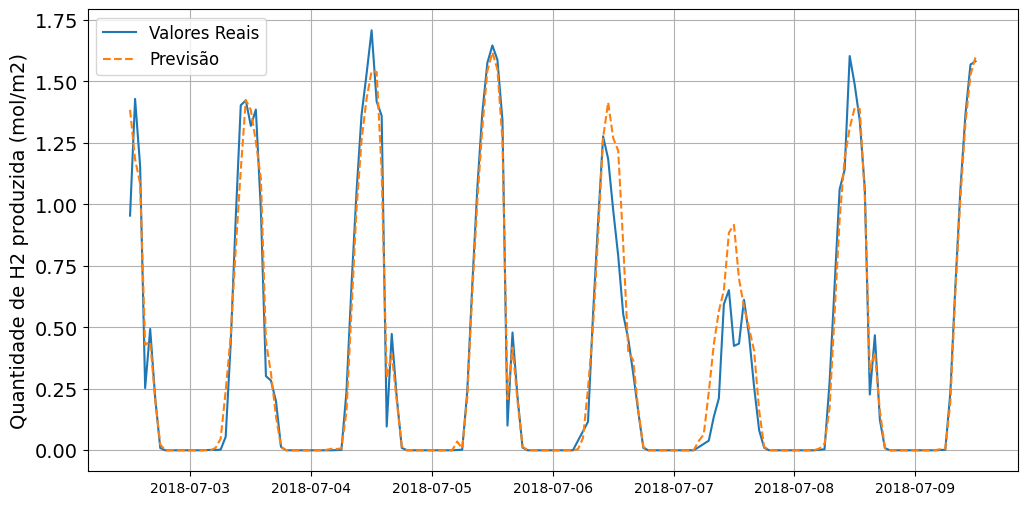

In [43]:
# 📈 5. Plotar gráfico
# 7 dias
obs = 24 * 7

plt.figure(figsize=(12, 6))
plt.plot(n_h2_test[:obs+1], label='Valores Reais')
plt.plot(n_h2_pred[:obs+1], "--", label='Previsão')
# plt.title('Valores Reais vs Previsões (Random Forest)')
# plt.xlabel('Observações')

plt.ylabel('Quantidade de H2 produzida (mol/m2)', fontsize=14)
plt.xticks(fontsize=10)
# plt.xticks(ticks=range(0, obs+1, 24), fontsize=10)
plt.yticks(fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

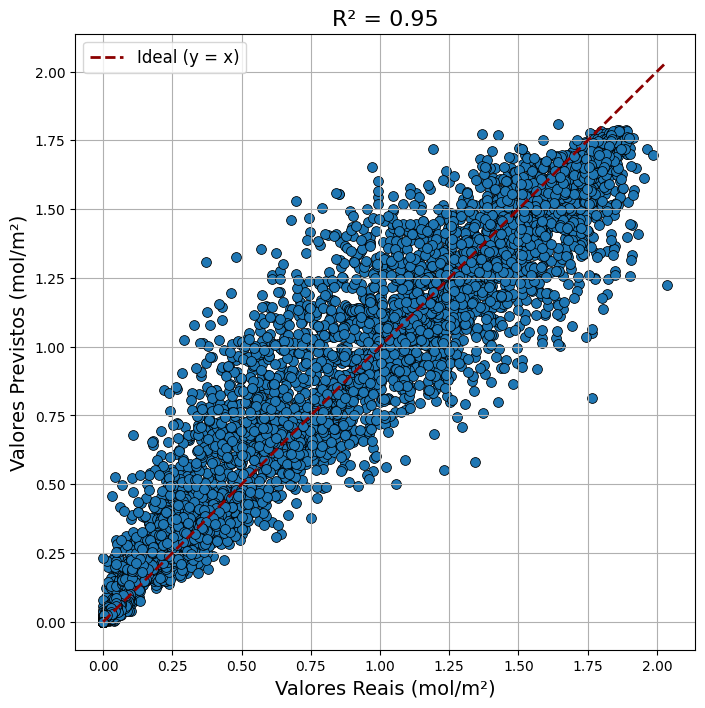

In [44]:
import seaborn as sns

# Calcular o R²
r2_rf_h2 = r2_score(n_h2_test, n_h2_pred)

# Criar o gráfico de dispersão
plt.figure(figsize=(8, 8))
# sns.scatterplot(x=n_h2_test, y=n_h2_pred, s=50, color='blue', edgecolor='k')
sns.scatterplot(x=n_h2_test, y=n_h2_pred, s=50, edgecolor='k')

# Linha de referência (y = x)
max_val = max(max(n_h2_test), max(n_h2_pred))
min_val = min(min(n_h2_test), min(n_h2_pred))
plt.plot([min_val, max_val], [min_val, max_val], '--', color='darkred', linewidth=2, label='Ideal (y = x)')

# Personalização
plt.xlabel('Valores Reais (mol/m²)', fontsize=14)
plt.ylabel('Valores Previstos (mol/m²)', fontsize=14)
plt.title(f'R² = {r2_rf_h2:.2f}', fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

# SVR

In [45]:
# 📌 a. Load do modelo
svr_model.fit(X_tr_top, Y_tr_scaled)
# svr_model = models["SVR"]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=10, epsilon=0.001)

In [46]:
# 📌 b. Fazer previsões
y_pred_svr = svr_model.predict(X_ts_top)

In [48]:
# 📌 c. Inverter o Min-Max Scaling
y_pred_inversed_svr = scaler_Y.inverse_transform(y_pred_svr.reshape(-1, 1)).ravel()
y_test_inversed_svr = scaler_Y.inverse_transform(Y_ts_scaled.values.reshape(-1, 1)).ravel()
# y_pred_inversed_rf = scaler_Y_lstm.inverse_transform(y_pred_rf)
# y_test_inversed_rf = scaler_Y_lstm.inverse_transform(Y_ts_scaled)

In [49]:
# 📌 d. Calcular as métricas
mae_svr = mean_absolute_error(y_test_inversed_svr, y_pred_inversed_svr)
rmse_svr = np.sqrt(mean_squared_error(y_test_inversed_svr, y_pred_inversed_svr))
r2_svr = r2_score(y_test_inversed_svr, y_pred_inversed_svr)

# 📌 e. Exibir os resultados
print(f"Random Forest - MAE: {mae_svr:.4f}, RMSE: {rmse_svr:.4f}, R²: {r2_svr:.4f}")

Random Forest - MAE: 153.0162, RMSE: 298.6320, R²: 0.9373


In [50]:
# Converter o array em Series com o mesmo índice de X_ts_top
y_test_inv_series_svr = pd.Series(y_test_inversed_svr.flatten(), index=X_ts_top.index)
y_pred_inv_series_svr = pd.Series(y_pred_inversed_svr.flatten(), index=X_ts_top.index)

In [51]:
# Transformação em Qtde de H2 produzida
eta_fv = 0.22
eta_pc = 0.85

eta_ele = 0.755
hhv_h2 = 285.83   # kJ/mol

E_fv_test_svr = y_test_inv_series_svr * eta_fv * eta_pc   # Energia produzida em kJ/m2
E_fv_pred_svr = y_pred_inv_series_svr * eta_fv * eta_pc   # Energia produzida em kJ/m2

n_h2_test_svr = E_fv_test_svr * eta_ele / hhv_h2   # kJ/m2 * mol / kJ ==> mol/m2
n_h2_pred_svr = E_fv_pred_svr * eta_ele / hhv_h2   # mol/m2

In [52]:
# 📌 Calcular as métricas em unidade de H2 produzido
mae_h2_svr = mean_absolute_error(n_h2_test_svr, n_h2_pred_svr)
rmse_h2_svr = np.sqrt(mean_squared_error(n_h2_test_svr, n_h2_pred_svr))
r2_h2_svr = r2_score(n_h2_test_svr, n_h2_pred_svr)

# 📌 e. Exibir os resultados
print(f"Random Forest - MAE: {mae_h2_svr:.4f}, RMSE_svr: {rmse_h2_svr:.4f}, R²: {r2_h2_svr:.4f}")

Random Forest - MAE: 0.0756, RMSE_svr: 0.1475, R²: 0.9373


In [53]:
# n_h2_test e n_h2_pred indice para datetime
n_h2_test_svr.index = pd.to_datetime(n_h2_test_svr.index)
n_h2_pred_svr.index = pd.to_datetime(n_h2_pred_svr.index)

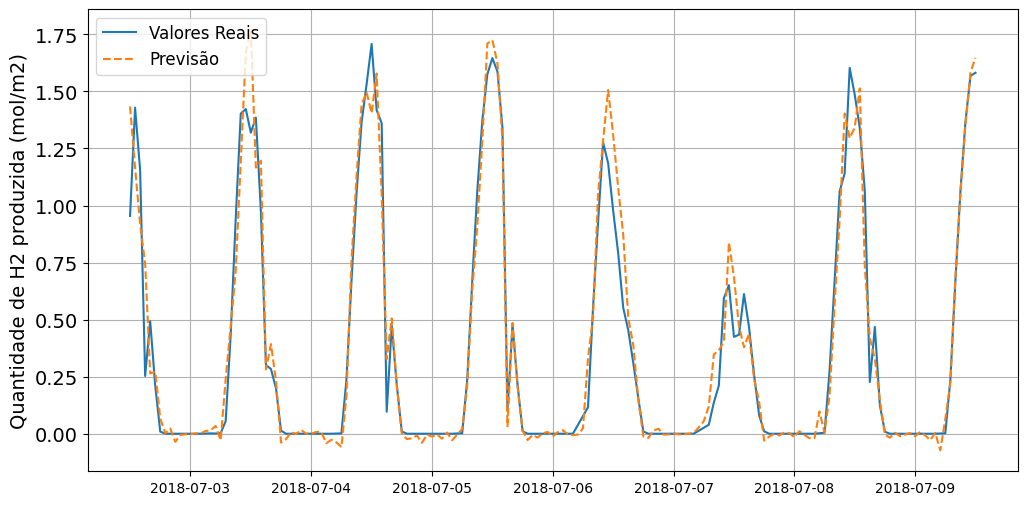

In [54]:
# 📈 5. Plotar gráfico
# 7 dias
obs = 24 * 7

plt.figure(figsize=(12, 6))
plt.plot(n_h2_test_svr[:obs+1], label='Valores Reais')
plt.plot(n_h2_pred_svr[:obs+1], "--", label='Previsão')
# plt.title('Valores Reais vs Previsões (Random Forest)')
# plt.xlabel('Observações')
plt.ylabel('Quantidade de H2 produzida (mol/m2)', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

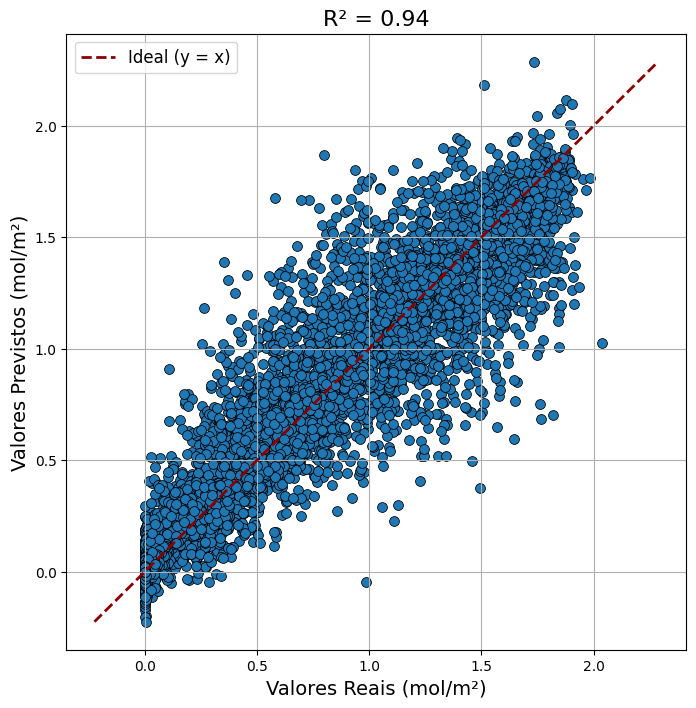

In [55]:
import seaborn as sns

# Calcular o R²
r2_h2_svr = r2_score(n_h2_test_svr, n_h2_pred_svr)

# Criar o gráfico de dispersão
plt.figure(figsize=(8, 8))
# sns.scatterplot(x=n_h2_test, y=n_h2_pred, s=50, color='blue', edgecolor='k')
sns.scatterplot(x=n_h2_test_svr, y=n_h2_pred_svr, s=50, edgecolor='k')

# Linha de referência (y = x)
max_val = max(max(n_h2_test_svr), max(n_h2_pred_svr))
min_val = min(min(n_h2_test_svr), min(n_h2_pred_svr))
plt.plot([min_val, max_val], [min_val, max_val], '--', color='darkred', linewidth=2, label='Ideal (y = x)')

# Personalização
plt.xlabel('Valores Reais (mol/m²)', fontsize=14)
plt.ylabel('Valores Previstos (mol/m²)', fontsize=14)
plt.title(f'R² = {r2_h2_svr:.2f}', fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

# XGBoost

In [80]:
# !pip uninstall -y scikit-learn
# !pip install scikit-learn==1.3.1

Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 94.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.3.1 which is incompatible.


In [25]:
# 📌 a. Load do modelo
xgboost_model.fit(X_tr_top, Y_tr_scaled)
# xgboost_model = models["XGBoost"]

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=7, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [26]:
# 📌 b. Fazer previsões
y_pred_xgboost = xgboost_model.predict(X_ts_top)

In [30]:
# 📌 c. Inverter o Min-Max Scaling
y_pred_inversed_xgboost = scaler_Y.inverse_transform(y_pred_xgboost.reshape(-1, 1)).ravel()
# y_test_inversed_xgboost = scaler_Y.inverse_transform(Y_ts_scaled.reshape(-1, 1)).ravel()
y_test_inversed_xgboost = scaler_Y.inverse_transform(Y_ts_scaled.values.reshape(-1, 1)).ravel()
# y_pred_inversed_rf = scaler_Y_lstm.inverse_transform(y_pred_rf)
# y_test_inversed_rf = scaler_Y_lstm.inverse_transform(Y_ts_scaled)

In [31]:
# 📌 d. Calcular as métricas
mae_xgboost = mean_absolute_error(y_test_inversed_xgboost, y_pred_inversed_xgboost)
rmse_xgboost = np.sqrt(mean_squared_error(y_test_inversed_xgboost, y_pred_inversed_xgboost))
r2_xgboost = r2_score(y_test_inversed_xgboost, y_pred_inversed_xgboost)

# 📌 e. Exibir os resultados
print(f"Random Forest - MAE: {mae_xgboost:.4f}, RMSE: {rmse_xgboost:.4f}, R²: {r2_xgboost:.4f}")

Random Forest - MAE: 119.4476, RMSE: 250.4144, R²: 0.9559


In [32]:
# Converter o array em Series com o mesmo índice de X_ts_top
y_test_inv_series_xgboost = pd.Series(y_test_inversed_xgboost.flatten(), index=X_ts_top.index)
y_pred_inv_series_xgboost = pd.Series(y_pred_inversed_xgboost.flatten(), index=X_ts_top.index)

In [33]:
# Transformação em Qtde de H2 produzida
eta_fv = 0.22
eta_pc = 0.85

eta_ele = 0.755
hhv_h2 = 285.83   # kJ/mol

E_fv_test_xgboost = y_test_inv_series_xgboost * eta_fv * eta_pc   # Energia produzida em kJ/m2
E_fv_pred_xgboost = y_pred_inv_series_xgboost * eta_fv * eta_pc   # Energia produzida em kJ/m2

n_h2_test_xgboost = E_fv_test_xgboost * eta_ele / hhv_h2   # kJ/m2 * mol / kJ ==> mol/m2
n_h2_pred_xgboost = E_fv_pred_xgboost * eta_ele / hhv_h2   # mol/m2

In [34]:
# 📌 Calcular as métricas em unidade de H2 produzido
mae_h2_xgboost = mean_absolute_error(n_h2_test_xgboost, n_h2_pred_xgboost)
rmse_h2_xgboost = np.sqrt(mean_squared_error(n_h2_test_xgboost, n_h2_pred_xgboost))
r2_h2_xgboost = r2_score(n_h2_test_xgboost, n_h2_pred_xgboost)

# 📌 e. Exibir os resultados
print(f"Random Forest - MAE: {mae_h2_xgboost:.4f}, RMSE_svr: {rmse_h2_xgboost:.4f}, R²: {r2_h2_xgboost:.4f}")

Random Forest - MAE: 0.0590, RMSE_svr: 0.1237, R²: 0.9559


In [35]:
# n_h2_test e n_h2_pred indice para datetime
n_h2_test_xgboost.index = pd.to_datetime(n_h2_test_xgboost.index)
n_h2_pred_xgboost.index = pd.to_datetime(n_h2_pred_xgboost.index)

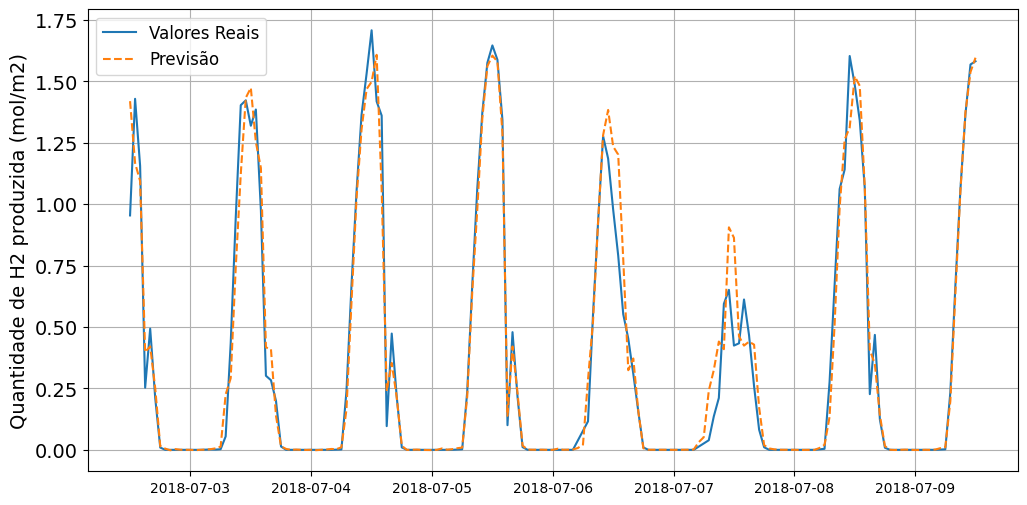

In [36]:
# 📈 5. Plotar gráfico
# 7 dias
obs = 24 * 7

plt.figure(figsize=(12, 6))
plt.plot(n_h2_test_xgboost[:obs+1], label='Valores Reais')
plt.plot(n_h2_pred_xgboost[:obs+1], "--", label='Previsão')
# plt.title('Valores Reais vs Previsões (Random Forest)')
# plt.xlabel('Observações')
plt.ylabel('Quantidade de H2 produzida (mol/m2)', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

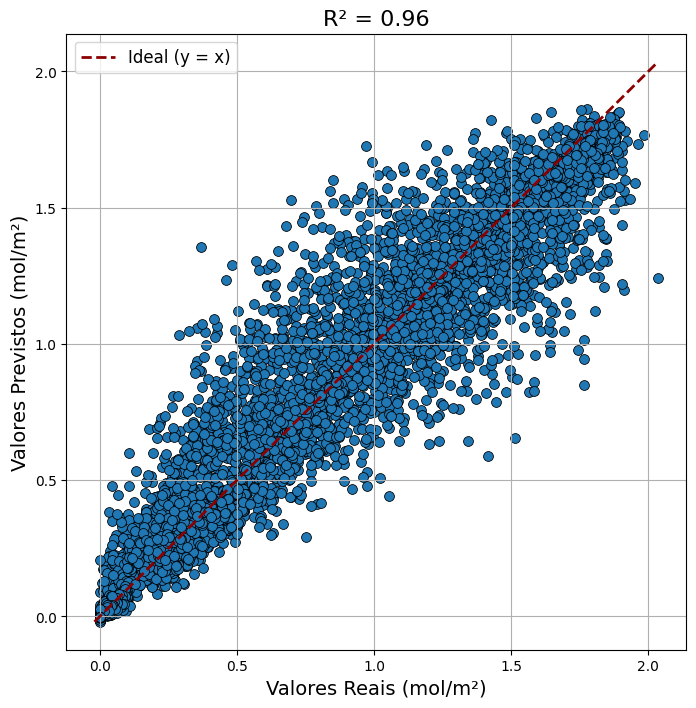

In [37]:
import seaborn as sns

# Calcular o R²
r2_h2_xgboost = r2_score(n_h2_test_xgboost, n_h2_pred_xgboost)

# Criar o gráfico de dispersão
plt.figure(figsize=(8, 8))
# sns.scatterplot(x=n_h2_test, y=n_h2_pred, s=50, color='blue', edgecolor='k')
sns.scatterplot(x=n_h2_test_xgboost, y=n_h2_pred_xgboost, s=50, edgecolor='k')

# Linha de referência (y = x)
max_val = max(max(n_h2_test_xgboost), max(n_h2_pred_xgboost))
min_val = min(min(n_h2_test_xgboost), min(n_h2_pred_xgboost))
plt.plot([min_val, max_val], [min_val, max_val], '--', color='darkred', linewidth=2, label='Ideal (y = x)')

# Personalização
plt.xlabel('Valores Reais (mol/m²)', fontsize=14)
plt.ylabel('Valores Previstos (mol/m²)', fontsize=14)
plt.title(f'R² = {r2_h2_xgboost:.2f}', fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

# LSTM

Preparação dos dados

In [59]:
features_target = ["precipitacao_total_horario", "pressao_atmosferica_nivel_estacao_horaria", "temperatura_ar_bulbo_seco_horaria", "umidade_relativa_ar_horaria", "vento_direcao_horaria", "vento_rajada_maxima", "vento_velocidade_horaria", "radiacao_global"]
data_filt = data[features_target]

# Separar variável target e features
target = 'radiacao_global'
X = data_filt.drop(columns=[target])
y = data_filt[target]

In [60]:
from sklearn.preprocessing import MinMaxScaler
# Escalar os dados
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

In [61]:
# Definição do número de timesteps (quantidade de passos anteriores usados para prever)
timesteps = 24  # 24 horas anteriores

# Criar sequências para treino
X_lstm, y_lstm = [], []

for i in range(timesteps, len(X_scaled)):
    X_lstm.append(X_scaled[i-timesteps:i])
    y_lstm.append(y_scaled[i])

X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

In [62]:
from sklearn.model_selection import train_test_split

X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y_lstm, test_size=0.3, shuffle=False)

In [63]:
# Divisão sequencial para validação
train_size = int(len(X_train_lstm) * 0.8)  # 80% treino, 20% validação
X_train_seq, X_val_seq = X_train_lstm[:train_size], X_train_lstm[train_size:]
y_train_seq, y_val_seq = y_train_lstm[:train_size], y_train_lstm[train_size:]

# a. Fit do modelo
history_random_search = lstm_model_instance.fit(
    X_train_lstm, y_train_lstm,
    batch_size=hyperparameters["LSTM"]["batch_size"],
    epochs=hyperparameters["LSTM"]["epochs"],
    validation_data=(X_val_seq, y_val_seq),
    verbose=2
)

Epoch 1/50
959/959 - 22s - 23ms/step - loss: 0.0224 - val_loss: 0.0115
Epoch 2/50
959/959 - 23s - 24ms/step - loss: 0.0128 - val_loss: 0.0094
Epoch 3/50
959/959 - 39s - 41ms/step - loss: 0.0114 - val_loss: 0.0085
Epoch 4/50
959/959 - 19s - 20ms/step - loss: 0.0105 - val_loss: 0.0081
Epoch 5/50
959/959 - 21s - 22ms/step - loss: 0.0098 - val_loss: 0.0076
Epoch 6/50
959/959 - 20s - 20ms/step - loss: 0.0094 - val_loss: 0.0076
Epoch 7/50
959/959 - 21s - 21ms/step - loss: 0.0094 - val_loss: 0.0073
Epoch 8/50
959/959 - 21s - 22ms/step - loss: 0.0092 - val_loss: 0.0074
Epoch 9/50
959/959 - 20s - 20ms/step - loss: 0.0090 - val_loss: 0.0071
Epoch 10/50
959/959 - 18s - 19ms/step - loss: 0.0088 - val_loss: 0.0076
Epoch 11/50
959/959 - 20s - 21ms/step - loss: 0.0088 - val_loss: 0.0070
Epoch 12/50
959/959 - 18s - 19ms/step - loss: 0.0087 - val_loss: 0.0075
Epoch 13/50
959/959 - 21s - 22ms/step - loss: 0.0087 - val_loss: 0.0071
Epoch 14/50
959/959 - 21s - 21ms/step - loss: 0.0085 - val_loss: 0.0066
E

In [64]:
lstm_model_instance.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 24, 32)              │           5,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,421 (157.90 KB)

 Trainable params: 13,473 (52.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 26,948 (105.27 KB)

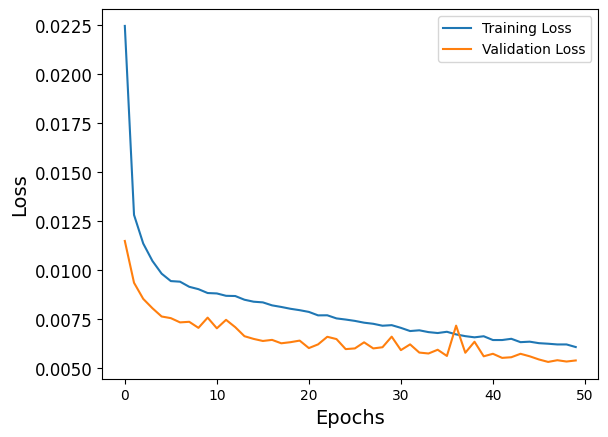

In [65]:
# plot da loss
plt.plot(
    lstm_model_instance.history.history['loss'],
    label='Training Loss'
)
plt.plot(
    lstm_model_instance.history.history['val_loss'],
    label='Validation Loss'
)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)
# plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [66]:
# 📌 b. Fazer previsões
y_pred_lstm = lstm_model_instance.predict(X_test_lstm)

411/411 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


In [71]:
# 📌 c. Inverter o Min-Max Scaling
y_pred_inversed_lstm = scaler_Y_lstm.inverse_transform(y_pred_lstm.reshape(-1, 1)).ravel()
# y_test_inversed_lstm = scaler_Y_lstm.inverse_transform(Y_ts_scaled.reshape(-1, 1)).ravel()
y_test_inversed_lstm = scaler_Y.inverse_transform(Y_ts_scaled.values.reshape(-1, 1)).ravel()
# y_pred_inversed_rf = scaler_Y_lstm.inverse_transform(y_pred_rf)
# y_test_inversed_rf = scaler_Y_lstm.inverse_transform(Y_ts_scaled)

In [72]:
# 📌 d. Calcular as métricas
mae_lstm = mean_absolute_error(y_test_inversed_lstm, y_pred_inversed_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_test_inversed_lstm, y_pred_inversed_lstm))
r2_lstm = r2_score(y_test_inversed_lstm, y_pred_inversed_lstm)

# 📌 e. Exibir os resultados
print(f"Random Forest - MAE: {mae_lstm:.4f}, RMSE: {rmse_lstm:.4f}, R²: {r2_lstm:.4f}")

Random Forest - MAE: 180.5529, RMSE: 360.3457, R²: 0.9087


In [73]:
# Converter o array em Series com o mesmo índice de X_ts_top
y_test_inv_series_lstm = pd.Series(y_test_inversed_lstm.flatten(), index=X_ts_top.index)
y_pred_inv_series_lstm = pd.Series(y_pred_inversed_lstm.flatten(), index=X_ts_top.index)

In [74]:
# Transformação em Qtde de H2 produzida
eta_fv = 0.22
eta_pc = 0.85

eta_ele = 0.755
hhv_h2 = 285.83   # kJ/mol

E_fv_test_lstm = y_test_inv_series_lstm * eta_fv * eta_pc   # Energia produzida em kJ/m2
E_fv_pred_lstm = y_pred_inv_series_lstm * eta_fv * eta_pc   # Energia produzida em kJ/m2

n_h2_test_lstm = E_fv_test_lstm * eta_ele / hhv_h2   # kJ/m2 * mol / kJ ==> mol/m2
n_h2_pred_lstm = E_fv_pred_lstm * eta_ele / hhv_h2   # mol/m2

In [79]:
# 📌 Calcular as métricas em unidade de H2 produzido
mae_h2_lstm = mean_absolute_error(n_h2_test_lstm, n_h2_pred_lstm)
rmse_h2_lstm = np.sqrt(mean_squared_error(n_h2_test_lstm, n_h2_pred_lstm))
r2_h2_lstm = r2_score(n_h2_test_lstm, n_h2_pred_lstm)

# 📌 e. Exibir os resultados
print(f"Random Forest - MAE: {mae_h2_lstm:.4f}, RMSE_svr: {rmse_h2_lstm:.4f}, R²: {r2_h2_lstm:.4f}")

Random Forest - MAE: 0.0892, RMSE_svr: 0.1780, R²: 0.9087


In [76]:
# n_h2_test e n_h2_pred indice para datetime
n_h2_test_lstm.index = pd.to_datetime(n_h2_test_lstm.index)
n_h2_pred_lstm.index = pd.to_datetime(n_h2_pred_lstm.index)

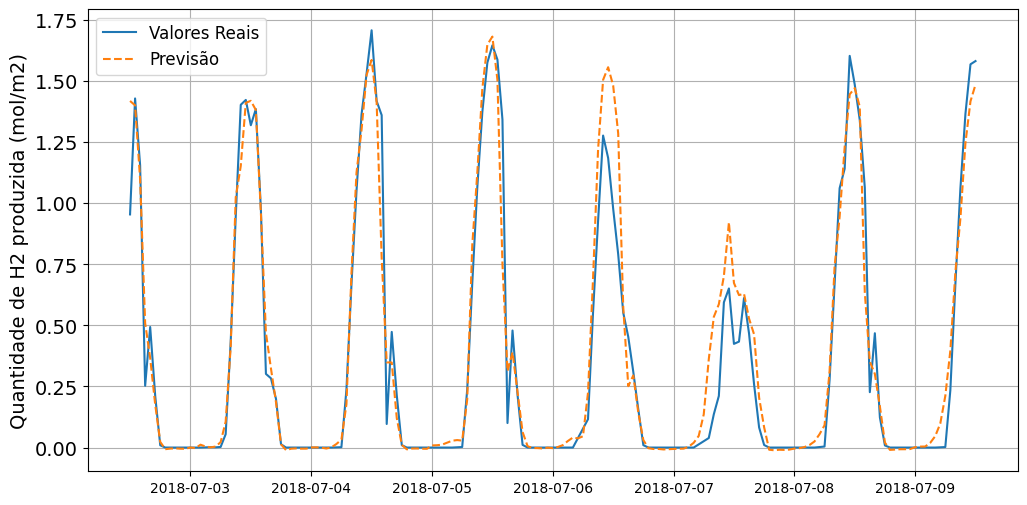

In [77]:
# 📈 5. Plotar gráfico
# 7 dias
obs = 24 * 7

plt.figure(figsize=(12, 6))
plt.plot(n_h2_test_lstm[:obs+1], label='Valores Reais')
plt.plot(n_h2_pred_lstm[:obs+1], "--", label='Previsão')
# plt.title('Valores Reais vs Previsões (Random Forest)')
# plt.xlabel('Observações')
plt.ylabel('Quantidade de H2 produzida (mol/m2)', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

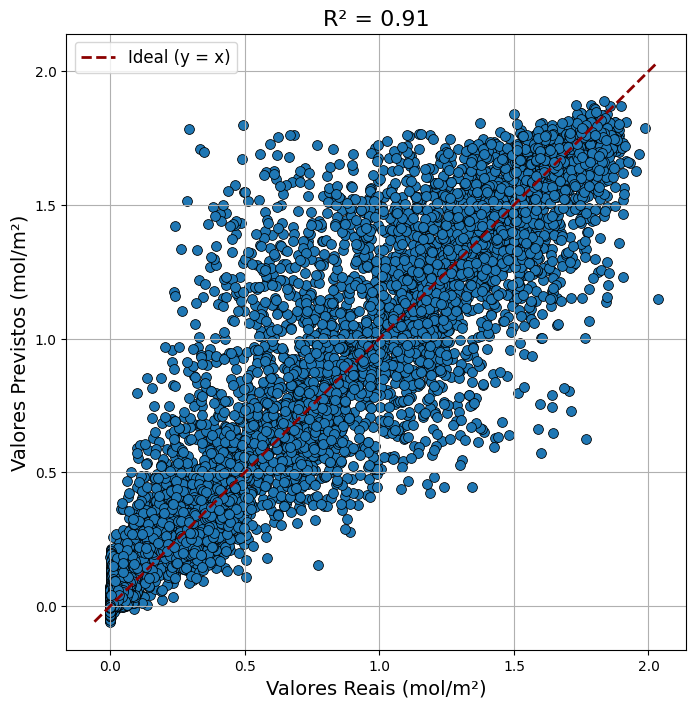

In [78]:
import seaborn as sns

# Calcular o R²
r2_h2_lstm = r2_score(n_h2_test_lstm, n_h2_pred_lstm)

# Criar o gráfico de dispersão
plt.figure(figsize=(8, 8))
# sns.scatterplot(x=n_h2_test, y=n_h2_pred, s=50, color='blue', edgecolor='k')
sns.scatterplot(x=n_h2_test_lstm, y=n_h2_pred_lstm, s=50, edgecolor='k')

# Linha de referência (y = x)
max_val = max(max(n_h2_test_lstm), max(n_h2_pred_lstm))
min_val = min(min(n_h2_test_lstm), min(n_h2_pred_lstm))
plt.plot([min_val, max_val], [min_val, max_val], '--', color='darkred', linewidth=2, label='Ideal (y = x)')

# Personalização
plt.xlabel('Valores Reais (mol/m²)', fontsize=14)
plt.ylabel('Valores Previstos (mol/m²)', fontsize=14)
plt.title(f'R² = {r2_h2_lstm:.2f}', fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()